#Set up Environment

In [1]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Tue Aug  6 12:18:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
!git clone https://github.com/Omid-Nejati/MedViT.git
%cd /content/MedViT

Cloning into 'MedViT'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 176 (delta 87), reused 134 (delta 61), pack-reused 1
Receiving objects: 100% (176/176), 820.48 KiB | 2.58 MiB/s, done.
Resolving deltas: 100% (87/87), done.
/content/MedViT


In [4]:
pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (

In [5]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchsummary import summary

from tqdm import tqdm
import medmnist
from medmnist import INFO, Evaluator

import torchattacks
from torchattacks import PGD, FGSM

#Dataset

In [6]:
name_model='Chay+0'
name_data='16EzAabrHUNh2V5PIlkYX7qGJIGrxpQmq'

##Tải dataset

In [7]:
import os
import shutil

def empty_directory(directory):
    """
    Làm trống một thư mục bằng cách xóa tất cả các tệp và thư mục bên trong.
    """
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f"Không thể xóa {file_path}. Lỗi: {e}")

# Sử dụng hàm để làm trống thư mục
if os.path.exists("/content/extracted_files"):
  empty_directory("/content/extracted_files")

In [8]:
import gdown
import zipfile

# Đường dẫn đến file zip trên Google Drive
zip_url = 'https://drive.google.com/uc?id='+name_data

# Tên thư mục chứa file giải nén
extracted_folder = '/content/extracted_files'

# Tải xuống file zip
zip_path = '/content/downloaded_file.zip'
gdown.download(zip_url, zip_path, quiet=False)

# Giải nén file zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

# Hiển thị danh sách các file đã giải nén
extracted_files = os.listdir(extracted_folder)
print("Các file đã giải nén:", extracted_files)



Downloading...
From (original): https://drive.google.com/uc?id=16EzAabrHUNh2V5PIlkYX7qGJIGrxpQmq
From (redirected): https://drive.google.com/uc?id=16EzAabrHUNh2V5PIlkYX7qGJIGrxpQmq&confirm=t&uuid=84888920-8883-498a-942c-dc56568f13ce
To: /content/downloaded_file.zip
100%|██████████| 49.1M/49.1M [00:01<00:00, 27.4MB/s]


Các file đã giải nén: ['train_labels.txt', 'val', 'test', 'test_labels.txt', 'val_labels.txt', 'train']


##Xử lý dữ liệu

In [9]:
import json
import cv2
import os
import numpy as np

# Đường dẫn tới thư mục chứa dữ liệu train và test
train_folder = '/content/extracted_files/train'
val_folder = '/content/extracted_files/val'
test_folder = '/content/extracted_files/test'

def load_images_and_labels(folder,file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    images=[]
    labels=[]
    names=[]
    for line in lines:
        parts = line.split(':')
        filename = parts[0]  # Tên tệp ảnh (giữ nguyên dấu cách nếu có)
        label = int(parts[1].strip())     # Nhãn

        img_path = os.path.join(folder, filename)
        if img_path.endswith('.jpg') or img_path.endswith('.png'):
              try:
                  image = cv2.imread(img_path)
                  # Chuyển đổi màu sắc từ BGR sang RGB (OpenCV đọc ảnh dưới dạng BGR)
                  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                  image = cv2.resize(image, (224, 224))  # Ví dụ resize ảnh về kích thước 224x224
                  images.append(image)
                  labels.append(label)
                  names.append(filename)
              except Exception as e:
                print(f"Error processing image {img_path}: {e}")

    return np.array(images), np.array(labels)

In [10]:

# Load dữ liệu train và test
train_images, train_labels = load_images_and_labels(train_folder, '/content/extracted_files/train_labels.txt')
val_images, val_labels = load_images_and_labels(val_folder, '/content/extracted_files/val_labels.txt')
test_images, test_labels = load_images_and_labels(test_folder, '/content/extracted_files/test_labels.txt')

# Tiếp theo, bạn có thể tiến hành các bước tiền xử lý dữ liệu cần thiết và sử dụng chúng để huấn luyện mô hình.
download = True

NUM_EPOCHS = 10
BATCH_SIZE = 10
lr = 0.005

task="ordinal-regression" #Hồi quy thứ bậc
n_channels = 3  #Ảnh đen trắng thì 1, RGB là 3
n_classes = len(np.unique(train_labels))


In [11]:
print("Số lớp là:",n_classes)
# In số lượng dữ liệu trong tập train và test
print(f"Number of train samples: {len(train_images)}")
print(f"Number of val samples: {len(val_images)}")
print(f"Number of test samples: {len(test_images)}")

Số lớp là: 3
Number of train samples: 167
Number of val samples: 48
Number of test samples: 24


#Cân bằng dữ liệu trước

In [12]:
import cv2
import numpy as np
import random
from PIL import Image, ImageEnhance, ImageFilter
from scipy.ndimage import gaussian_filter, map_coordinates

def random_erasing(image, p=0.5, s=(0.02, 0.4), r=(0.3, 3)):
    if random.uniform(0, 1) > p:
        return image

    img_h, img_w, _ = image.shape
    while True:
        area = img_h * img_w
        target_area = random.uniform(*s) * area
        aspect_ratio = random.uniform(*r)

        h = int(round(np.sqrt(target_area * aspect_ratio)))
        w = int(round(np.sqrt(target_area / aspect_ratio)))

        if w < img_w and h < img_h:
            x1 = random.randint(0, img_h - h)
            y1 = random.randint(0, img_w - w)
            image[x1:x1+h, y1:y1+w, :] = np.random.randint(0, 255, (h, w, 3), dtype=np.uint8)
            return image

def elastic_transform(image, alpha, sigma, alpha_affine):
    random_state = np.random.RandomState(None)
    shape = image.shape
    shape_size = shape[:2]

    # Affine transformation
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size,
                       [center_square[0]+square_size, center_square[1]-square_size],
                       center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    # Elastic deformation
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

def add_gaussian_noise(image, mean=0, sigma=25):
    gaussian = np.random.normal(mean, sigma, image.shape)  # Gaussian noise
    noisy_image = np.clip(image + gaussian, 0, 255).astype(np.uint8)
    return noisy_image

def adjust_contrast(image, factor=1.5):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=factor, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

def augment_image(image):
    np.random.seed(45)  # Thiết lập seed cho NumPy
    augmented_images = []

    # Convert image to OpenCV format
    image = np.array(image)

    # Random Erasing
    erased_image = random_erasing(image.copy())
    augmented_images.append(erased_image)

    # Elastic Transformations
    elastic_image = elastic_transform(image.copy(), alpha=720, sigma=24, alpha_affine=24)
    augmented_images.append(elastic_image)

    # Gaussian Noise
    noisy_image = add_gaussian_noise(image.copy())
    augmented_images.append(noisy_image)

    # Contrast Adjustment
    contrast_image = adjust_contrast(image.copy())
    augmented_images.append(contrast_image)

    return augmented_images

def balance_dataset(images, labels):
    np.random.seed(45)  # Thiết lập seed cho NumPy

    # Đếm số lượng phần tử của mỗi nhãn
    unique_labels, counts = np.unique(labels, return_counts=True)

    # Tìm nhãn có số lượng lớn nhất
    max_count = np.max(counts)
    max_label = unique_labels[np.argmax(counts)]

    balanced_images = []
    balanced_labels = []

    # Lặp qua mỗi nhãn
    for label in unique_labels:
        label_indices = np.where(labels == label)[0]
        current_images = images[label_indices]
        current_labels = labels[label_indices]

        # Thêm các hình ảnh hiện tại vào danh sách
        balanced_images.extend(current_images)
        balanced_labels.extend(current_labels)

        # Nếu số lượng hình ảnh của nhãn hiện tại ít hơn số lượng hình ảnh của nhãn nhiều nhất, tăng cường dữ liệu
        while len(current_images) < max_count:
            for image in current_images:
                pil_image = Image.fromarray(image)
                augmented_images = augment_image(pil_image)

                for aug_image in augmented_images:
                    if len(current_images) >= max_count:
                        break
                    balanced_images.append(aug_image)
                    balanced_labels.append(label)
                    current_images = np.append(current_images, [aug_image], axis=0)

    return np.array(balanced_images), np.array(balanced_labels)


Kiểm thử hàm cân bằng ở tập train

In [13]:
train_images0, train_labels0 = balance_dataset(train_images, train_labels)

from collections import Counter

# Đếm số lượng mỗi nhãn trong tập train_labels
train_label_counts = Counter(train_labels)
print("Số lượng ảnh của mỗi label ban đầu")
for label, count in train_label_counts.items():
    print(f"Label {label}: {count} samples")

# In số lượng mỗi nhãn trong tập train_labels_augmented
train_label_counts = Counter(train_labels0)
print("Số lượng ảnh mỗi label sau khi cân bằng")
for label, count in train_label_counts.items():
    print(f"Label {label}: {count} samples")

Số lượng ảnh của mỗi label ban đầu
Label 0: 64 samples
Label 1: 39 samples
Label 2: 64 samples
Số lượng ảnh mỗi label sau khi cân bằng
Label 0: 64 samples
Label 1: 64 samples
Label 2: 64 samples


##Hàm tăng cường dữ liệu ảnh

In [14]:


import random
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter

def augment_image(image, num_augments=10):
    np.random.seed(45)  # Thiết lập seed cho NumPy
    augmented_images = []

    image = np.array(image)  # Convert PIL image to NumPy array

    for _ in range(num_augments):
        # Randomly choose an augmentation method
        method = random.choice(['random_erasing', 'elastic_transform','gauss_noise', 'adjust_contrast'])

        if method == 'random_erasing':
            augmented_image = random_erasing(image.copy())
        elif method == 'elastic_transform':
            augmented_image = elastic_transform(image.copy(), alpha=720, sigma=24, alpha_affine=24)
        elif method == 'gauss_noise':
            augmented_image = add_gaussian_noise(image.copy())
        elif method == 'adjust_contrast':
            augmented_image = adjust_contrast(image.copy())
        augmented_images.append(augmented_image)

    return augmented_images

def augment_dataset(images, labels, num_augments=10):
    np.random.seed(45)  # Thiết lập seed cho NumPy

    augmented_images = []
    augmented_labels = []

    for i in range(len(images)):
        image = Image.fromarray(images[i])
        aug_images = augment_image(image, num_augments=num_augments)

        augmented_images.extend(aug_images)
        augmented_labels.extend([labels[i]] * num_augments)

    return np.array(augmented_images), np.array(augmented_labels)


# Giả sử train_images, train_labels, test_images, test_labels đã được load từ trước
# Tăng cường dữ liệu train và test
train_images_augmented, train_labels_augmented = augment_dataset(train_images0, train_labels0, num_augments=10)
val_images_augmented, val_labels_augmented = augment_dataset(val_images, val_labels, num_augments=10)
test_images_augmented, test_labels_augmented = augment_dataset(val_images, val_labels, num_augments=1)
# In số lượng dữ liệu trong tập train và test sau khi tăng cường
print(f"Ảnh tập train sau khi tăng cường: {len(train_images_augmented)}")
print(f"Ảnh tập val sau khi tăng cường: {len(val_images_augmented)}")
print(f"Ảnh tập val sau khi tăng cường: {len(test_images_augmented)}")

Ảnh tập train sau khi tăng cường: 1920
Ảnh tập val sau khi tăng cường: 480
Ảnh tập val sau khi tăng cường: 48


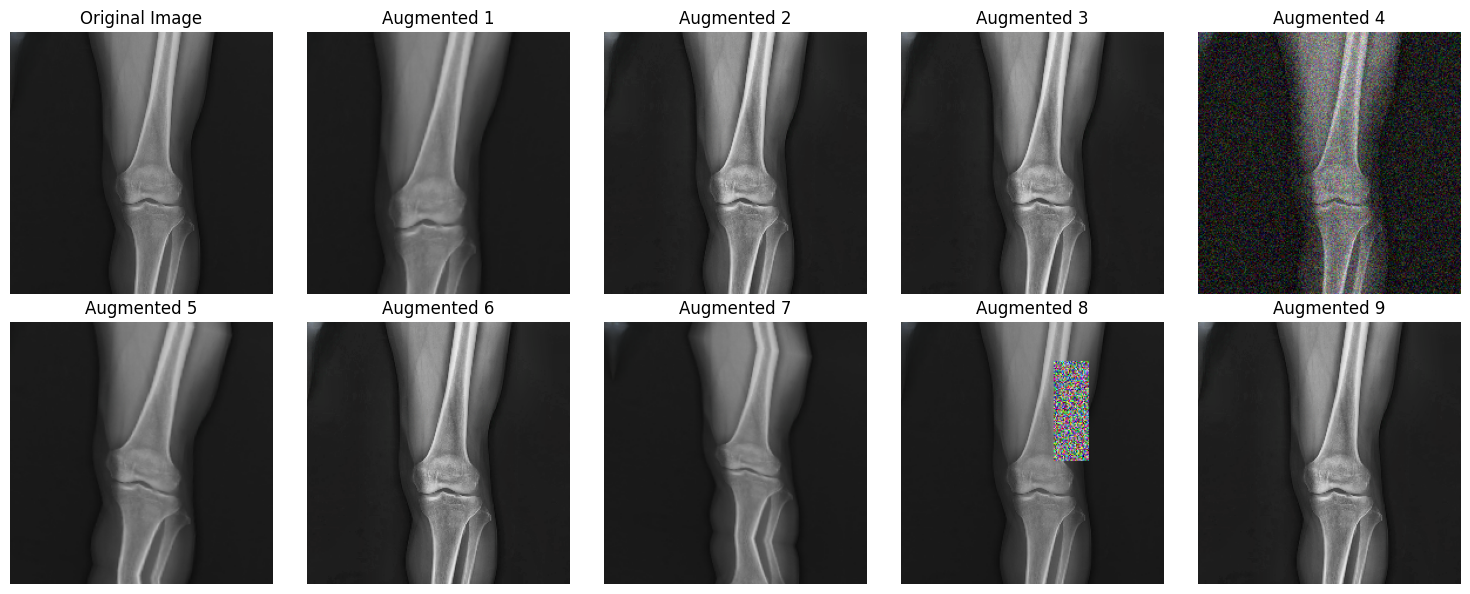

In [15]:
# Chọn một ảnh gốc từ tập dữ liệu huấn luyện
original_image = train_images[0]

# Tăng cường dữ liệu cho ảnh đó (tạo ra 10 ảnh tăng cường)
augmented_images = augment_dataset([original_image], [train_labels[0]], num_augments=10)[0]

# Hiển thị 1 ảnh gốc và 10 ảnh tăng cường
plt.figure(figsize=(15, 6))
plt.subplot(2, 5, 1)  # 2 hàng, 5 cột, ảnh đầu tiên
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')

for i in range(9):
    plt.subplot(2, 5, i + 2)  # Bắt đầu từ ảnh thứ 2 đến thứ 11
    plt.title(f"Augmented {i+1}")
    if i==7:
      plt.imshow(augmented_images[i+2])
    else:
      plt.imshow(augmented_images[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

##Định nghĩa lớp kế thừa dưới dạng pytorch dataset




In [16]:

from torch.utils.data import Dataset
class DiseaseData(Dataset):
    def __init__(self, X, y):
        # convert into PyTorch tensors and remember them
        self.X = torch.tensor(X.transpose(0, 3, 1, 2), dtype=torch.float32)  # Chuyển đổi kích thước của ảnh
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        # this should return the size of the dataset
        return len(self.X)

    def __getitem__(self, idx):
        # this should return one sample from the dataset
        names = self.X[idx]
        labels = self.y[idx]
        return names, labels


In [17]:
from torchvision.transforms.transforms import Resize

# load the data
train_dataset = DiseaseData(train_images_augmented, train_labels_augmented)
val_dataset = DiseaseData(val_images_augmented, val_labels_augmented)


# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False, drop_last=True)

#Model

In [18]:
# Function to set the random seed
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

##ECB+EATFormer

In [19]:
from functools import partial
import math
import torch
import torch.utils.checkpoint as checkpoint

from einops import rearrange, reduce, repeat
from torchvision.ops import DeformConv2d
import torch.nn.functional as F

from einops import rearrange
from timm.models.layers import DropPath, trunc_normal_
from timm.models.registry import register_model

from torch import nn

init_alpha_value = 1e-3
init_scale_values = 1e-4
NORM_EPS = 1e-5

def merge_pre_bn(model):
    """Gộp các lớp BatchNorm vào các lớp Conv2d trước chúng."""
    for module in model.modules():
        if isinstance(module, nn.BatchNorm2d):
            # Lấy lớp Conv2d liền kề trước lớp BatchNorm
            conv = module.previous_module  # Bạn cần sửa phần này tùy thuộc vào cấu trúc mô hình của bạn
            if isinstance(conv, nn.Conv2d):
                with torch.no_grad():
                    # Gộp trọng số BatchNorm vào Conv2d
                    conv.weight.data = conv.weight.data * (module.weight / module.running_var.sqrt())
                    conv.bias.data = module.bias - (module.weight / module.running_var.sqrt()) * module.running_mean
                # Xóa lớp BatchNorm sau khi gộp
                module.previous_module = None
    return model

# ========== For Common ==========
class LayerNormConv(nn.Module):
    """Lớp chuẩn hóa LayerNorm cho dữ liệu 4D, thường dùng trong các mô hình học sâu."""

    def __init__(self, normalized_shape, eps=1e-6, elementwise_affine=True):
        super().__init__()
        self.norm = nn.LayerNorm(normalized_shape, eps, elementwise_affine)

    def forward(self, x):
        x = rearrange(x, 'b c h w -> b h w c').contiguous()
        x = self.norm(x)
        x = rearrange(x, 'b h w c -> b c h w').contiguous()
        return x

def get_norm(norm_layer='in_1d'):
    """Trả về lớp chuẩn hóa dựa trên tên được cung cấp."""
    eps = 1e-6
    norm_dict = {
        'none': nn.Identity,
        'in_1d': partial(nn.InstanceNorm1d, eps=eps),
        'in_2d': partial(nn.InstanceNorm2d, eps=eps),
        'in_3d': partial(nn.InstanceNorm3d, eps=eps),
        'bn_1d': partial(nn.BatchNorm1d, eps=eps),
        'bn_2d': partial(nn.BatchNorm2d, eps=eps),
        # 'bn_2d': partial(nn.SyncBatchNorm, eps=eps),
        'bn_3d': partial(nn.BatchNorm3d, eps=eps),
        'gn': partial(nn.GroupNorm, eps=eps),
        'ln': partial(nn.LayerNorm, eps=eps),
        'lnc': partial(LayerNormConv, eps=eps),
    }
    return norm_dict[norm_layer]

from torch.nn import Sigmoid, ReLU, ReLU6, PReLU, GELU, SiLU

class HardSigmoid(nn.Module):
    """Hàm kích hoạt HardSigmoid."""
    def forward(self, x):
        return F.hardtanh(x, min_val=0, max_val=1)

class HardSwish(nn.Module):
    """Hàm kích hoạt HardSwish."""
    def forward(self, x):
        return x * F.hardtanh(x + 3, min_val=0, max_val=6) / 6

class Swish(nn.Module):
    """Hàm kích hoạt Swish."""
    def forward(self, x):
        return x * torch.sigmoid(x)

class Mish(nn.Module):
    """Hàm kích hoạt Mish."""
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

class HardMish(nn.Module):
    """Hàm kích hoạt HardMish."""
    def forward(self, x):
        return x * torch.relu6(x + 3) / 6

def get_act(act_layer='relu'):
    """Trả về hàm kích hoạt dựa trên tên được cung cấp."""
    act_dict = {
        'none': nn.Identity,
        'sigmoid': Sigmoid,
        'swish': Swish,
        'mish': Mish,
        'hsigmoid': HardSigmoid,
        'hswish': HardSwish,
        'hmish': HardMish,
        'tanh': nn.Tanh,
        'relu': nn.ReLU,
        'relu6': nn.ReLU6,
        'prelu': PReLU,
        'gelu': GELU,
        'silu': nn.SiLU
    }
    return act_dict[act_layer]

class MLP(nn.Module):
    """Multilayer Perceptron với các lớp Conv2d và hàm kích hoạt."""

    def __init__(self, in_dim, hid_dim=None, out_dim=None, act_layer='gelu', drop=0.):
        super().__init__()
        out_dim = out_dim or in_dim
        hid_dim = hid_dim or in_dim
        self.fc1 = nn.Conv2d(in_dim, hid_dim, kernel_size=1, stride=1, padding=0)
        self.act = get_act(act_layer)()
        self.fc2 = nn.Conv2d(hid_dim, out_dim, kernel_size=1, stride=1, padding=0)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class FFN(nn.Module):
    """Feed-Forward Network với LayerNorm, MLP, và DropPath."""

    def __init__(self, dim, mlp_ratio=4., drop=0., drop_path=0., act_layer='gelu', norm_layer='lnc'):
        super().__init__()
        self.norm = get_norm(norm_layer)(dim)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        hid_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_dim=dim, hid_dim=hid_dim, out_dim=dim, act_layer=act_layer, drop=drop)
        self.gamma_mlp = nn.Parameter(init_scale_values * torch.ones((dim)), requires_grad=True)

    def forward(self, x):
        shortcut = x
        x = self.norm(x)
        x = shortcut + self.drop_path(self.gamma_mlp.unsqueeze(0).unsqueeze(2).unsqueeze(3) * self.mlp(x))
        return x

# ========== Tập hợp Toàn Cục và cục bộ ==========
class MSA(nn.Module):
    def __init__(self, dim, dim_head, qkv_bias=False, attn_drop=0., proj_drop=0.):
        """
        Mô-đun Attention Tự Nhân Đầu (MSA).

        :param dim: Số lượng kênh đầu vào.
        :param dim_head: Kích thước của mỗi đầu attention.
        :param qkv_bias: Có thêm bias vào các phép chiếu q, k, v hay không.
        :param attn_drop: Tỷ lệ dropout cho trọng số attention.
        :param proj_drop: Tỷ lệ dropout cho phép chiếu đầu ra.
        """
        super().__init__()
        self.dim_head = dim_head
        self.num_head = dim // dim_head
        self.scale = self.dim_head ** -0.5

        # Chiếu các tensor q, k, v (query, key, value)
        self.qkv = nn.Conv2d(dim, dim * 3, kernel_size=1, stride=1, padding=0, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Conv2d(dim, dim, kernel_size=1, stride=1, padding=0)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        """
        Phương thức truyền dữ liệu cho MSA.

        :param x: Tensor đầu vào có dạng (B, C, H, W).
        :return: Tensor đầu ra sau khi áp dụng attention tự nhân.
        """
        B, C, H, W = x.shape

        # Lấy các tensor q, k, v
        qkv = self.qkv(x)
        qkv = rearrange(qkv, 'b (qkv heads dim_head) h w -> qkv b heads (h w) dim_head', qkv=3, heads=self.num_head, dim_head=self.dim_head).contiguous()
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Tính toán điểm attention
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        # Áp dụng attention lên các giá trị
        x = attn @ v
        x = rearrange(x, 'b heads (h w) dim_head -> b (heads dim_head) h w', heads=self.num_head, dim_head=self.dim_head, h=H, w=W).contiguous()
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class MSA_OP(nn.Module):
    def __init__(self, dim, dim_head, window_size, qkv_bias=False, attn_drop=0., proj_drop=0., init_scale_values=1e-4):
        """
        Mô-đun Attention Tự Nhân với Kích Thước Cửa Sổ (MSA_OP).

        :param dim: Số lượng kênh đầu vào.
        :param dim_head: Kích thước của mỗi đầu attention.
        :param window_size: Kích thước cửa sổ để chia hình ảnh.
        :param qkv_bias: Có thêm bias vào các phép chiếu q, k, v hay không.
        :param attn_drop: Tỷ lệ dropout cho trọng số attention.
        :param proj_drop: Tỷ lệ dropout cho phép chiếu đầu ra.
        :param init_scale_values: Giá trị khởi tạo cho gamma.
        """
        super().__init__()
        assert dim % dim_head == 0
        self.window_size = window_size
        self.msa = MSA(dim, dim_head, qkv_bias, attn_drop, proj_drop)
        self.gamma_msa = nn.Parameter(init_scale_values * torch.ones((dim)), requires_grad=True)

    def forward(self, x):
        """
        Phương thức truyền dữ liệu cho MSA_OP.

        :param x: Tensor đầu vào có dạng (B, C, H, W).
        :return: Tensor đầu ra sau khi áp dụng MSA_OP.
        """
        B, C, H, W = x.shape
        if self.window_size <= 0:
            window_size_W, window_size_H = W, H
        else:
            window_size_W, window_size_H = self.window_size, self.window_size
        pad_l, pad_t = 0, 0
        pad_r = (window_size_W - W % window_size_W) % window_size_W
        pad_b = (window_size_H - H % window_size_H) % window_size_H
        x = F.pad(x, (pad_l, pad_r, pad_t, pad_b, 0, 0,))

        n1, n2 = (H + pad_b) // window_size_H, (W + pad_r) // window_size_W
        x = rearrange(x, 'b c (h1 n1) (w1 n2) -> (b n1 n2) c h1 w1', n1=n1, n2=n2).contiguous()
        x = self.gamma_msa.unsqueeze(0).unsqueeze(2).unsqueeze(3) * self.msa(x)
        x = rearrange(x, '(b n1 n2) c h1 w1 -> b c (h1 n1) (w1 n2)', n1=n1, n2=n2).contiguous()

        if pad_r > 0 or pad_b > 0:
            x = x[:, :, :H, :W].contiguous()
        return x


class DMSA(nn.Module):
    def __init__(self, dim, dim_head, kernel_size, stride, qkv_bias=False, attn_drop=0., proj_drop=0., d_groups=3):
        """
        Mô-đun Attention Địa Phương và Toàn Cục (DMSA).

        :param dim: Số lượng kênh đầu vào.
        :param dim_head: Kích thước của mỗi đầu attention.
        :param kernel_size: Kích thước của kernel cho các phép chiếu.
        :param stride: Kích thước của bước dịch cho các phép chiếu.
        :param qkv_bias: Có thêm bias vào các phép chiếu q, k, v hay không.
        :param attn_drop: Tỷ lệ dropout cho trọng số attention.
        :param proj_drop: Tỷ lệ dropout cho phép chiếu đầu ra.
        :param d_groups: Số lượng nhóm cho các phép chiếu địa phương.
        """
        super().__init__()
        assert dim % dim_head == 0
        self.kernel_size = kernel_size
        self.stride = stride
        self.dim = dim
        self.dim_head = dim_head
        self.num_head = dim // dim_head
        self.scale = self.dim_head ** -0.5
        self.d_groups = d_groups
        self.n_group_dim = self.dim // self.d_groups
        self.offset_range_factor = 2

        # Mô-đun điều chỉnh offset
        self.conv_offset_modulation = nn.Sequential(
            nn.Conv2d(self.n_group_dim, self.n_group_dim, self.kernel_size, self.stride, self.kernel_size // 2, groups=self.n_group_dim),
            get_norm('bn_2d')(self.n_group_dim),
            nn.GELU(),
            nn.Conv2d(self.n_group_dim, 3, 1, 1, 0, bias=False)
        )
        self.modulation_act = get_act('sigmoid')()
        self.q = nn.Conv2d(dim, dim * 1, kernel_size=1, stride=1, padding=0, bias=qkv_bias)
        self.kv = nn.Conv2d(dim, dim * 2, kernel_size=1, stride=1, padding=0, bias=qkv_bias)
        self.proj = nn.Conv2d(dim, dim, kernel_size=1, stride=1, padding=0, bias=True)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj_drop = nn.Dropout(proj_drop)

    @torch.no_grad()
    def _get_ref_points(self, H, W, B, dtype, device):
        """
        Tạo điểm tham chiếu cho các phép lấy mẫu địa phương.

        :param H: Chiều cao của đầu vào.
        :param W: Chiều rộng của đầu vào.
        :param B: Số lượng batch.
        :param dtype: Kiểu dữ liệu.
        :param device: Thiết bị tính toán.
        :return: Điểm tham chiếu cho các phép lấy mẫu.
        """
        ref_y, ref_x = torch.meshgrid(torch.linspace(0.5, H - 0.5, H, dtype=dtype, device=device),
                                      torch.linspace(0.5, W - 0.5, W, dtype=dtype, device=device))
        ref = torch.stack((ref_y, ref_x), -1)
        ref[..., 1].div_(W).mul_(2).sub_(1)
        ref[..., 0].div_(H).mul_(2).sub_(1)
        ref = ref[None, ...].expand(B * self.d_groups, -1, -1, -1)  # B * g H W 2
        return ref

    def forward(self, x):
        """
        Phương thức truyền dữ liệu cho DMSA.

        :param x: Tensor đầu vào có dạng (B, C, H, W).
        :return: Tensor đầu ra sau khi áp dụng DMSA.
        """
        B, C, H, W = x.shape
        q = self.q(x)
        q_off = rearrange(q, 'b (g c) h w -> (b g) c h w', g=self.d_groups, c=self.n_group_dim).contiguous()
        offset_modulation = self.conv_offset_modulation(q_off)  # bg 3 h w
        offset, modulation = offset_modulation[:, 0:2, :, :], self.modulation_act(offset_modulation[:, 2:3, :, :])  # bg 2 h w, bg 1 h w
        H_off, W_off = offset.size(2), offset.size(3)

        offset_range = torch.tensor([1.0 / H_off, 1.0 / W_off], device=x.device).reshape(1, 2, 1, 1)
        offset = offset.tanh().mul(offset_range).mul(self.offset_range_factor)
        offset = rearrange(offset, 'b c h w -> b h w c').contiguous()
        reference = self._get_ref_points(H_off, W_off, B, x.dtype, x.device)
        pos = offset + reference

        x_sampled = F.grid_sample(input=x.reshape(B * self.d_groups, self.n_group_dim, H, W),
                                  grid=pos[..., (1, 0)],  # y, x -> x, y
                                  mode='bilinear', align_corners=True)  # B * g, Cg, Hg, Wg
        x_sampled *= modulation.sigmoid()
        x_sampled = rearrange(x_sampled, '(b g) c h w -> b (g c) h w', b=B, g=self.d_groups).contiguous()
        q = rearrange(q, 'b (heads dim_head) h w -> b heads (h w) dim_head', heads=self.num_head,
                      dim_head=self.dim_head).contiguous()
        kv = self.kv(x_sampled)
        kv = rearrange(kv, 'b (kv heads dim_head) h w -> kv b heads (h w) dim_head', kv=2, heads=self.num_head,
                       dim_head=self.dim_head).contiguous()
        k, v = kv[0], kv[1]

        # Tính toán điểm attention
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        # Áp dụng attention lên các giá trị
        x = attn @ v
        x = rearrange(x, 'b heads (h w) dim_head -> b (heads dim_head) h w', heads=self.num_head,
                      dim_head=self.dim_head, h=H, w=W).contiguous()
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class DMSA_OP(nn.Module):
    def __init__(self, dim, dim_head, window_size, kernel_size, stride, qkv_bias=False, attn_drop=0., proj_drop=0., d_groups=3):
        """
        Mô-đun Attention Địa Phương và Toàn Cục với Kích Thước Cửa Sổ (DMSA_OP).

        :param dim: Số lượng kênh đầu vào.
        :param dim_head: Kích thước của mỗi đầu attention.
        :param window_size: Kích thước cửa sổ để chia hình ảnh.
        :param kernel_size: Kích thước của kernel cho các phép chiếu.
        :param stride: Kích thước của bước dịch cho các phép chiếu.
        :param qkv_bias: Có thêm bias vào các phép chiếu q, k, v hay không.
        :param attn_drop: Tỷ lệ dropout cho trọng số attention.
        :param proj_drop: Tỷ lệ dropout cho phép chiếu đầu ra.
        :param d_groups: Số lượng nhóm cho các phép chiếu địa phương.
        """
        super().__init__()
        self.window_size = window_size
        self.mdmsa = DMSA(dim, dim_head, kernel_size, stride, qkv_bias, attn_drop, proj_drop, d_groups)
        self.gamma_mdmsa = nn.Parameter(init_scale_values * torch.ones((dim)), requires_grad=True)

    def forward(self, x):
        """
        Phương thức truyền dữ liệu cho DMSA_OP.

        :param x: Tensor đầu vào có dạng (B, C, H, W).
        :return: Tensor đầu ra sau khi áp dụng DMSA_OP.
        """
        B, C, H, W = x.shape
        if self.window_size <= 0:
            window_size_W, window_size_H = W, H
        else:
            window_size_W, window_size_H = self.window_size, self.window_size
        pad_l, pad_t = 0, 0
        pad_r = (window_size_W - W % window_size_W) % window_size_W
        pad_b = (window_size_H - H % window_size_H) % window_size_H
        x = F.pad(x, (pad_l, pad_r, pad_t, pad_b, 0, 0,))

        n1, n2 = (H + pad_b) // window_size_H, (W + pad_r) // window_size_W
        x = rearrange(x, 'b c (h1 n1) (w1 n2) -> (b n1 n2) c h1 w1', n1=n1, n2=n2).contiguous()
        x = self.gamma_mdmsa.unsqueeze(0).unsqueeze(2).unsqueeze(3) * self.mdmsa(x)
        x = rearrange(x, '(b n1 n2) c h1 w1 -> b c (h1 n1) (w1 n2)', n1=n1, n2=n2).contiguous()

        if pad_r > 0 or pad_b > 0:
            x = x[:, :, :H, :W].contiguous()
        return x

# ========== Conv_OP ==========
class Conv_OP(nn.Module):
    def __init__(self, dim, kernel_size, stride=1):
        super().__init__()
        # Tính toán padding dựa trên kích thước kernel và stride
        padding = math.ceil((kernel_size - stride) / 2)
        # Convolution 2D với nhóm (group) = dim
        self.conv1 = nn.Conv2d(dim, dim, kernel_size, stride, padding, groups=dim)
        # Chuẩn hóa với Batch Normalization
        self.norm1 = get_norm('bn_2d')(dim)
        # Hàm kích hoạt SiLU (Sigmoid Linear Unit)
        self.act1 = get_act('silu')()
        # Convolution 2D với kích thước kernel = 1
        self.conv2 = nn.Conv2d(dim, dim, 1, 1, 0)

    def forward(self, x):
        # Áp dụng convolution đầu tiên, chuẩn hóa, kích hoạt và sau đó convolution thứ hai
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.act1(x)
        x = self.conv2(x)
        return x


# ========== DCN2_OP ==========
class DCN2_OP(nn.Module):
    # ref: https://github.com/WenmuZhou/DBNet.pytorch/blob/678b2ae55e018c6c16d5ac182558517a154a91ed/models/backbone/resnet.py
    def __init__(self, dim, kernel_size=3, stride=1, deform_groups=4):
        super().__init__()
        # Số kênh offset dựa trên kích thước kernel
        offset_channels = kernel_size * kernel_size * 2
        # Convolution 2D để tính toán offset
        self.conv1_offset = nn.Conv2d(dim, deform_groups * offset_channels, kernel_size=3, stride=stride, padding=1)
        # Deformable Convolution 2D với kernel_size
        self.conv1 = DeformConv2d(dim, dim, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        # Chuẩn hóa với Batch Normalization
        self.norm1 = get_norm('bn_2d')(dim)
        # Hàm kích hoạt SiLU (Sigmoid Linear Unit)
        self.act1 = get_act('silu')()
        # Convolution 2D với kích thước kernel = 1
        self.conv2 = nn.Conv2d(dim, dim, 1, 1, 0)

    def forward(self, x):
        # Tính toán offset và áp dụng Deformable Convolution
        offset = self.conv1_offset(x)
        x = self.conv1(x, offset)
        x = self.norm1(x)
        x = self.act1(x)
        x = self.conv2(x)
        return x


# ========== GLI ==========
class GLI(nn.Module):
    def __init__(self, in_dim, dim_head, window_size, kernel_size=5, qkv_bias=False, drop=0., attn_drop=0.,
                 drop_path=0., act_layer='gelu', norm_layer='bn_2d',
                 op_names=['msa', 'mdmsa', 'conv', 'dcn'], d_group=3, gli_split=False, gli_weight=True, gli_ratio=None):
        super().__init__()
        # Danh sách các loại phép toán
        self.op_names = op_names
        self.gli_split = gli_split
        self.gli_weight = gli_weight
        self.gli_ratio = gli_ratio
        self.op_num = len(op_names)
        # Chuẩn hóa đầu vào
        self.norm = get_norm(norm_layer)(in_dim)
        # Drop path nếu có
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        if self.op_num == 1:
            dims = [in_dim]
        else:
            if gli_split:
                if gli_ratio:
                    assert self.op_num == 2
                    dims = [int(in_dim * gli_ratio), round(in_dim * (1 - gli_ratio))]
                else:
                    dim = in_dim // self.op_num
                    assert dim * self.op_num == in_dim
                    dims = [dim] * self.op_num
            else:
                dims = [in_dim] * self.op_num
        self.dims = dims
        self.ops = nn.ModuleList()
        for idx, op_name in enumerate(op_names):
            if op_name in ['conv', 'c']:
                op = Conv_OP(dims[idx], kernel_size, stride=1)
            elif op_name in ['dcn', 'dc']:
                op = DCN2_OP(dims[idx], kernel_size, stride=1, deform_groups=d_group)
            elif op_name in ['msa', 'm']:
                op = MSA_OP(dims[idx], dim_head, window_size, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
            elif op_name in ['mdmsa', 'dm']:
                op = DMSA_OP(dims[idx], dim_head, window_size, kernel_size=5, stride=1, qkv_bias=True, attn_drop=attn_drop, proj_drop=drop, d_groups=d_group)
            else:
                raise 'invalid \'{}\' operation'.format(op_name)
            self.ops.append(op)
        if self.op_num > 1 and gli_weight:
            self.alphas = nn.Parameter(init_alpha_value * torch.ones(self.op_num), requires_grad=True)

    def forward(self, x):
        # Shortcut kết nối
        shortcut = x
        x = self.norm(x)
        if self.op_num == 1:
            x = self.ops[0](x)
        else:
            if self.gli_split:
                if self.gli_ratio:
                    xs = [x[:, :self.dims[0], :, :], x[:, self.dims[0]:, :, :]]
                else:
                    xs = torch.chunk(x, self.op_num, dim=1)
            else:
                xs = [x] * self.op_num
            if self.gli_weight:
                alphas = F.softmax(self.alphas, dim=-1)
                if self.gli_split:
                    if self.gli_ratio:
                        x = torch.cat([self.ops[i](xs[i]) * alphas[i] for i in range(self.op_num)], dim=1).contiguous()
                    else:
                        xs = torch.cat([self.ops[i](xs[i]).unsqueeze(dim=-1) * alphas[i] for i in range(self.op_num)], dim=-1)
                        x = rearrange(xs, 'b c h w n -> b (c n) h w').contiguous()
                else:
                    xs = torch.cat([self.ops[i](xs[i]).unsqueeze(dim=-1) * alphas[i] for i in range(self.op_num)], dim=-1)
                    x = reduce(xs, 'b c h w n -> b c h w', 'mean').contiguous()
            else:
                if self.gli_split:
                    x = torch.cat([self.ops[i](xs[i]) for i in range(self.op_num)], dim=1)
                else:
                    xs = torch.cat([self.ops[i](xs[i]).unsqueeze(dim=-1) for i in range(self.op_num)], dim=-1)
                    x = reduce(xs, 'b c h w n -> b c h w', 'mean').contiguous()
        x = shortcut + self.drop_path(x)
        return x


# ========== Multi-Scale Populations ==========
class MSP(nn.Module):
    def __init__(self, in_dim, emb_dim, kernel_size=3, c_group=-1, stride=1, dilations=[1, 2, 3], msra_mode='cat',
                 act_layer='silu', norm_layer='bn_2d', msra_weight=True):
        super().__init__()
        self.msra_mode = msra_mode
        self.msra_weight = msra_weight
        self.dilation_num = len(dilations)

        # Xác nhận rằng c_group là giá trị hợp lệ
        if c_group == -1:
            c_group = math.gcd(in_dim, emb_dim)

        assert in_dim % c_group == 0, f'in_dim ({in_dim}) phải chia hết cho c_group ({c_group})'
        assert emb_dim % c_group == 0, f'emb_dim ({emb_dim}) phải chia hết cho c_group ({c_group})'

        self.convs = nn.ModuleList()
        for i in range(len(dilations)):
            # Tính toán padding cho convolution
            padding = math.ceil(((kernel_size - 1) * dilations[i] + 1 - stride) / 2)
            self.convs.append(nn.Sequential(
                nn.Conv2d(in_dim, emb_dim, kernel_size, stride, padding, dilations[i], groups=c_group),
                get_act(act_layer)()))

        if self.dilation_num > 1 and msra_weight:
            self.alphas = nn.Parameter(init_alpha_value * torch.ones(self.dilation_num), requires_grad=True)

        # Convolution cuối cùng để kết hợp các đầu ra
        self.conv_out = nn.Conv2d(emb_dim * (self.dilation_num if msra_mode == 'cat' else 1), emb_dim, kernel_size=1, stride=1, padding=0, bias=False)

    def forward(self, x):
        if self.dilation_num == 1:
            x = self.convs[0](x)
        else:
            if self.msra_weight:
                alphas = F.softmax(self.alphas, dim=-1)
                x = torch.cat([self.convs[i](x).unsqueeze(dim=-1) * alphas[i] for i in range(self.dilation_num)], dim=-1)
            else:
                x = torch.cat([self.convs[i](x).unsqueeze(dim=-1) for i in range(self.dilation_num)], dim=-1)

            if self.msra_mode == 'cat':
                x = rearrange(x, 'b c h w n -> b (c n) h w').contiguous()
            elif self.msra_mode == 'sum':
                x = reduce(x, 'b c h w n -> b c h w', 'mean').contiguous()

        x = self.conv_out(x)
        return x

# ========== MSRA ==========
class MSRA(nn.Module):
    def __init__(self, in_dim, emb_dim, kernel_size=3, c_group=-1, stride=1, dilations=[1, 2, 3], msra_mode='cat',
                 act_layer='silu', norm_layer='bn_2d', msra_weight=True, msra_norm=True, msra_skip=True, drop_path=0.):
        super().__init__()
        # Nếu msra_norm là True, áp dụng chuẩn hóa đầu vào
        self.norm = get_norm(norm_layer)(in_dim) if msra_norm else nn.Identity()
        # Khởi tạo lớp MSP với các tham số được cung cấp
        self.msp = MSP(in_dim, emb_dim, kernel_size, c_group, stride, dilations, msra_mode, act_layer, norm_layer, msra_weight)
        self.msra_skip = msra_skip

        # Nếu sử dụng skip connection
        if msra_skip:
            if in_dim != emb_dim:
                if stride == 1:
                    self.skip_conv = nn.Sequential(
                        nn.Conv2d(in_dim, emb_dim, kernel_size=1, stride=1, padding=0, bias=False),
                        get_norm(norm_layer)(emb_dim)
                    )
                else:
                    self.skip_conv = nn.Sequential(
                        nn.AvgPool2d(kernel_size=stride, stride=stride, ceil_mode=True, count_include_pad=False),
                        nn.Conv2d(in_dim, emb_dim, kernel_size=1, stride=1, padding=0, bias=False),
                        get_norm(norm_layer)(emb_dim)
                    )
            else:
                self.skip_conv = nn.Identity()

            # Drop path nếu có
            self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        else:
            self.skip_conv = nn.Identity()
            self.drop_path = nn.Identity()

    def forward(self, x):
        # Lưu lại đầu vào cho shortcut connection
        shortcut = x
        # Áp dụng chuẩn hóa và MSP
        x = self.msp(self.norm(x))

        # Nếu sử dụng skip connection
        if self.msra_skip:
            shortcut = self.skip_conv(shortcut)
            x = self.drop_path(x)
            x = shortcut + x
        else:
            x = self.drop_path(x)

        return x


# ========== EATBlock ==========
class EATBlock(nn.Module):
    def __init__(self, in_dim, emb_dim, stride=1, path_dropout=0, kernel_size=3, dilations=[1, 2, 3], norms=['bn_2d', 'bn_2d', 'bn_2d'],
                 msra_mode='cat', msra_weight=True, msra_norm=True, msra_skip=True,
                 dim_head=6, window_size=7, qkv_bias=True, drop=0., attn_drop=0., drop_path=0.,
                 op_names=['msa', 'conv'], d_group=3, c_group=-1, gli_split=False, gli_weight=True, gli_ratio=None, mlp_ratio=4.):
        super().__init__()
        # Khởi tạo lớp MSRA với các tham số được cung cấp
        self.layer1 = MSRA(in_dim, emb_dim, kernel_size, c_group, stride, dilations, msra_mode, 'silu', norms[0],
                           msra_weight, msra_norm, msra_skip, path_dropout)
        # Khởi tạo lớp GLI với các tham số được cung cấp
        self.layer2 = GLI(emb_dim, dim_head, window_size, 5, qkv_bias,
                           drop, attn_drop, drop_path, 'silu', norms[1],
                           op_names, d_group, gli_split, gli_weight, gli_ratio)
        # Khởi tạo lớp FFN với các tham số được cung cấp
        self.layer3 = FFN(emb_dim, mlp_ratio, drop, drop_path, 'gelu', norms[2])

    def forward(self, x):
        # Thực hiện từng lớp một theo thứ tự
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

#===================================================================================================

# ========== PatchEmbed ==========
class PatchEmbed(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(PatchEmbed, self).__init__()
        norm_layer = partial(nn.BatchNorm2d, eps=NORM_EPS)
        if stride == 2:
            # Nếu stride là 2, áp dụng Average Pooling trước khi Conv2d
            self.avgpool = nn.AvgPool2d((2, 2), stride=2, ceil_mode=True, count_include_pad=False)
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
            self.norm = norm_layer(out_channels)
        elif in_channels != out_channels:
            # Nếu số lượng kênh đầu vào không bằng số lượng kênh đầu ra, áp dụng Conv2d
            self.avgpool = nn.Identity()
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
            self.norm = norm_layer(out_channels)
        else:
            # Nếu số lượng kênh đầu vào và đầu ra giống nhau, không áp dụng Conv2d và chuẩn hóa
            self.avgpool = nn.Identity()
            self.conv = nn.Identity()
            self.norm = nn.Identity()

    def forward(self, x):
        return self.norm(self.conv(self.avgpool(x)))


# ========== Multi-Head Convolutional Attention (MHCA) ==========
class MHCA(nn.Module):
    """
    Multi-Head Convolutional Attention
    """
    def __init__(self, out_channels, head_dim):
        super(MHCA, self).__init__()
        norm_layer = partial(nn.BatchNorm2d, eps=NORM_EPS)
        # Khởi tạo nhóm Conv2d với kích thước kernel 3x3 và nhóm kênh
        self.group_conv3x3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1,
                                       padding=1, groups=out_channels // head_dim, bias=False)
        self.norm = norm_layer(out_channels)
        self.act = nn.ReLU(inplace=True)
        self.projection = nn.Conv2d(out_channels, out_channels, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.group_conv3x3(x)
        out = self.norm(out)
        out = self.act(out)
        out = self.projection(out)
        return out


# ========== H-Sigmoid ==========
class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6


# ========== H-Swish ==========
class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)


# ========== ECALayer ==========
class ECALayer(nn.Module):
    def __init__(self, channel, gamma=2, b=1, sigmoid=True):
        super(ECALayer, self).__init__()
        # Tính toán kích thước kernel dựa trên số lượng kênh và tham số gamma
        t = int(abs((math.log(channel, 2) + b) / gamma))
        k = t if t % 2 else t + 1

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k, padding=k // 2, bias=False)
        if sigmoid:
            self.sigmoid = nn.Sigmoid()
        else:
            self.sigmoid = h_sigmoid()

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv(y.squeeze(-1).transpose(-1, -2))
        y = y.transpose(-1, -2).unsqueeze(-1)
        y = self.sigmoid(y)
        return x * y.expand_as(x)


# ========== SEBlock ==========
class SELayer(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(channel, channel // reduction),
                nn.ReLU(inplace=True),
                nn.Linear(channel // reduction, channel),
                h_sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

# ========== LocalityFeedForward ==========
class LocalityFeedForward(nn.Module):
    def __init__(self, in_dim, out_dim, stride, expand_ratio=4., act='hs+se', reduction=4,
                 wo_dp_conv=False, dp_first=False):
        """
        :param in_dim: kích thước đầu vào
        :param out_dim: kích thước đầu ra
        :param stride: bước nhảy của convolution depth-wise
        :param expand_ratio: tỷ lệ mở rộng kích thước ẩn
        :param act: hàm kích hoạt.
                    relu: ReLU
                    hs: h_swish
                    hs+se: h_swish và SE module
                    hs+eca: h_swish và ECA module
                    hs+ecah: h_swish và ECA module. So với eca, sử dụng h_sigmoid.
        :param reduction: tỷ lệ giảm trong SE module.
        :param wo_dp_conv: không sử dụng convolution depth-wise.
        :param dp_first: đặt convolution depth-wise là lớp đầu tiên.
        """
        super(LocalityFeedForward, self).__init__()
        hidden_dim = int(in_dim * expand_ratio)
        kernel_size = 3

        layers = []
        # Lớp đầu tiên được thay thế bằng convolution 1x1.
        layers.extend([
            nn.Conv2d(in_dim, hidden_dim, 1, 1, 0, bias=False),
            nn.BatchNorm2d(hidden_dim),
            h_swish() if 'hs' in act else nn.ReLU6(inplace=True)])

        # Convolution depth-wise giữa hai lớp linear
        if not wo_dp_conv:
            dp = [
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, kernel_size // 2, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                h_swish() if 'hs' in act else nn.ReLU6(inplace=True)
            ]
            if dp_first:
                layers = dp + layers
            else:
                layers.extend(dp)

        if '+' in act:
            attn = act.split('+')[1]
            if attn == 'se':
                layers.append(SELayer(hidden_dim, reduction=reduction))
            elif 'eca' in attn:
                layers.append(ECALayer(hidden_dim, sigmoid=attn == 'eca'))
            else:
                raise NotImplementedError(f'Activation type {attn} is not implemented')

        # Lớp thứ hai được thay thế bằng convolution 1x1.
        layers.extend([
            nn.Conv2d(hidden_dim, out_dim, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_dim)
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        x = x + self.conv(x)
        return x


# ========== MlpECB ==========
class MlpECB(nn.Module):
    def __init__(self, in_features, out_features=None, mlp_ratio=None, drop=0., bias=True):
        super().__init__()
        out_features = out_features or in_features
        hidden_dim = _make_divisible(in_features * mlp_ratio, 32)
        self.conv1 = nn.Conv2d(in_features, hidden_dim, kernel_size=1, bias=bias)
        self.act = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(hidden_dim, out_features, kernel_size=1, bias=bias)
        self.drop = nn.Dropout(drop)

    def merge_bn(self, pre_norm):
        merge_pre_bn(self.conv1, pre_norm)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.conv2(x)
        x = self.drop(x)
        return x


# ========== ECB (Efficient Convolution Block) ==========
class ECB(nn.Module):
    """
    Efficient Convolution Block
    """
    def __init__(self, in_channels, out_channels, stride=1, path_dropout=0,
                 drop=0, head_dim=32, mlp_ratio=3):
        super(ECB, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        norm_layer = partial(nn.BatchNorm2d, eps=NORM_EPS)
        assert out_channels % head_dim == 0

        self.patch_embed = PatchEmbed(in_channels, out_channels, stride)
        self.mhca = MHCA(out_channels, head_dim)
        self.attention_path_dropout = DropPath(path_dropout)

        self.conv = LocalityFeedForward(out_channels, out_channels, 1, mlp_ratio, reduction=out_channels)

        self.norm = norm_layer(out_channels)
        self.is_bn_merged = False

    def merge_bn(self):
        if not self.is_bn_merged:
            self.mlpECB.merge_bn(self.norm)
            self.is_bn_merged = True

    def forward(self, x):
        x = self.patch_embed(x)
        x = x + self.attention_path_dropout(self.mhca(x))
        if not torch.onnx.is_in_onnx_export() and not self.is_bn_merged:
            out = self.norm(x)
        else:
            out = x
        x = x + self.conv(out) # (B, dim, 14, 14)
        return x


# ========== SEBlock (Squeeze-and-Excitation Block) ==========
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# ========== SEResidualBlock ==========
class SEResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, reduction=16):
        super(SEResidualBlock, self).__init__()
        # Các lớp convolution và BatchNorm
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels, reduction)
        # Lớp downsample để điều chỉnh kích thước đầu vào
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)
        out += residual
        out = self.relu(out)
        return out

# ========== BoneViT ==========
class BoneViT(nn.Module):
    def __init__(self, stem_chs, depths, path_dropout, attn_drop=0, drop=0, num_classes=1000,
                 strides=[1, 2, 2, 2], sr_ratios=[8, 4, 2, 1], head_dim=32, mix_block_ratio=0.75,
                 use_checkpoint=False):
        super(BoneViT, self).__init__()
        self.use_checkpoint = use_checkpoint

        # Các kênh đầu ra của từng giai đoạn
        self.stage_out_channels = [[96] * depths[0],
                                   [192] * (depths[1] - 1) + [256],
                                   [384] * (depths[2] - 1) + [512],
                                   [768] * (depths[3] - 1) + [1024]]

        # Các loại block cho từng giai đoạn
        self.stage_block_types = [[ECB] * depths[0],
                                  [ECB] * (depths[1] - 1) + [EATBlock],
                                  [ECB] * (depths[2] - 1) + [EATBlock],
                                  [ECB] * (depths[3] - 1) + [EATBlock]]

        # Lớp stem bao gồm các SEResidualBlock
        self.stem = nn.Sequential(
            SEResidualBlock(3, stem_chs[0], stride=2),
            SEResidualBlock(stem_chs[0], stem_chs[1], stride=1),
            SEResidualBlock(stem_chs[1], stem_chs[2], stride=1),
            SEResidualBlock(stem_chs[2], stem_chs[2], stride=2)
        )

        input_channel = stem_chs[-1]
        features = []
        idx = 0
        dpr = [x.item() for x in torch.linspace(0, path_dropout, sum(depths))]  # quy tắc giảm độ sâu ngẫu nhiên
        for stage_id in range(len(depths)):
            numrepeat = depths[stage_id]
            output_channels = self.stage_out_channels[stage_id]
            block_types = self.stage_block_types[stage_id]
            for block_id in range(numrepeat):
                if strides[stage_id] == 2 and block_id == 0:
                    stride = 2
                else:
                    stride = 1
                output_channel = output_channels[block_id]
                block_type = block_types[block_id]
                if block_type is ECB:
                    layer = ECB(input_channel, output_channel, stride=stride, path_dropout=dpr[idx + block_id],
                                drop=drop, head_dim=head_dim)
                    features.append(layer)
                elif block_type is EATBlock:
                    layer = EATBlock(input_channel, output_channel, stride=stride, path_dropout=dpr[idx + block_id],
                                     dim_head=head_dim, drop=drop, attn_drop=attn_drop)
                    features.append(layer)
                input_channel = output_channel
            idx += numrepeat
        self.features = nn.Sequential(*features)

        # Lớp BatchNorm cuối cùng
        self.norm = nn.BatchNorm2d(output_channel, eps=1e-5)

        # Lớp Average Pooling và Linear Projection
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.proj_head = nn.Sequential(
            nn.Linear(output_channel, num_classes),
        )

        # Chỉ số của các giai đoạn đầu ra
        self.stage_out_idx = [sum(depths[:idx + 1]) - 1 for idx in range(len(depths))]
        print('initialize_weights...')
        self._initialize_weights()

    def merge_bn(self):
        self.eval()
        for idx, module in self.named_modules():
            if isinstance(module, ECB) or isinstance(module, EATBlock):
                module.merge_bn()

    def _initialize_weights(self):
        for n, m in self.named_modules():
            if isinstance(m, (nn.BatchNorm2d, nn.GroupNorm, nn.LayerNorm, nn.BatchNorm1d)):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                trunc_normal_(m.weight, std=.02)
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv2d):
                trunc_normal_(m.weight, std=.02)
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.stem(x)
        for idx, layer in enumerate(self.features):
            if self.use_checkpoint:
                x = checkpoint.checkpoint(layer, x)
            else:
                x = layer(x)
        x = self.norm(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.proj_head(x)
        return x



"""
model = BoneViT(stem_chs=[64, 32, 64], depths=[3, 4, 30, 3], path_dropout=0.2)
model.proj_head[0] = nn.Linear(in_features=1024, out_features=n_classes, bias=True)
model.eval()
"""


'\nmodel = BoneViT(stem_chs=[64, 32, 64], depths=[3, 4, 30, 3], path_dropout=0.2)\nmodel.proj_head[0] = nn.Linear(in_features=1024, out_features=n_classes, bias=True)\nmodel.eval()\n'

##Model

In [20]:
#Tải model đã pretrained sẵn trên ChestMNIST
!pip install gdown
!gdown https://drive.google.com/uc?id=1tsqzCP946ah086dEtSgU-6dKt1D5nTC_ -O /content/chestMNIST_10.pth
set_seed(45)
device = torch.device('cuda')
model= torch.load('/content/chestMNIST_10.pth', map_location=device )
model.proj_head[0] = nn.Linear(in_features=1024, out_features=n_classes, bias=True)
model.eval()

Downloading...
From (original): https://drive.google.com/uc?id=1tsqzCP946ah086dEtSgU-6dKt1D5nTC_
From (redirected): https://drive.google.com/uc?id=1tsqzCP946ah086dEtSgU-6dKt1D5nTC_&confirm=t&uuid=b611aab7-be06-44a6-9fbd-242d0924daa3
To: /content/chestMNIST_10.pth
100% 274M/274M [00:02<00:00, 106MB/s]


BoneViT(
  (stem): Sequential(
    (0): SEResidualBlock(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SEBlock(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=64, out_features=4, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=4, out_features=64, bias=False)
          (3): Sigmoid()
        )
      )
      (downsample): Sequential(
        (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): SEResidu

In [21]:
# Di chuyển mô hình về CPU
model = model.cuda()

In [22]:
!pip install torchinfo

In [23]:

from torchinfo import summary
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
BoneViT                                                 [1, 3]                    --
├─Sequential: 1-1                                       [1, 64, 56, 56]           --
│    └─SEResidualBlock: 2-1                             [1, 64, 112, 112]         --
│    │    └─Sequential: 3-1                             [1, 64, 112, 112]         320
│    │    └─Conv2d: 3-2                                 [1, 64, 112, 112]         1,728
│    │    └─BatchNorm2d: 3-3                            [1, 64, 112, 112]         128
│    │    └─ReLU: 3-4                                   [1, 64, 112, 112]         --
│    │    └─Conv2d: 3-5                                 [1, 64, 112, 112]         36,864
│    │    └─BatchNorm2d: 3-6                            [1, 64, 112, 112]         128
│    │    └─SEBlock: 3-7                                [1, 64, 112, 112]         512
│    │    └─ReLU: 3-8                            

# Huấn luyện

##Chuẩn bị

In [24]:
#Định nghĩa hàm lỗi và bộ tối ưu
criterion = nn.CrossEntropyLoss()

# Cải tiến bộ tối ưu để tối ưu đúng trọng số
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

##Đóng băng các lớp

In [25]:
#Đóng băng tất cả lớp
for param in model.parameters():
    param.requires_grad = False

# Rã băng lớp cuối
# Thay thế'fc' với tên đúng của lớp cuối
for name, param in model.named_parameters():
    if 'fc' in name:  # Adjust 'fc' to the correct layer name
        param.requires_grad = True

# Kiểm tra đã đóng băng đúng chưa
for name, param in model.named_parameters():
    print(f"{name} requires_grad: {param.requires_grad}")

stem.0.conv1.weight requires_grad: False
stem.0.bn1.weight requires_grad: False
stem.0.bn1.bias requires_grad: False
stem.0.conv2.weight requires_grad: False
stem.0.bn2.weight requires_grad: False
stem.0.bn2.bias requires_grad: False
stem.0.se.fc.0.weight requires_grad: True
stem.0.se.fc.2.weight requires_grad: True
stem.0.downsample.0.weight requires_grad: False
stem.0.downsample.1.weight requires_grad: False
stem.0.downsample.1.bias requires_grad: False
stem.1.conv1.weight requires_grad: False
stem.1.bn1.weight requires_grad: False
stem.1.bn1.bias requires_grad: False
stem.1.conv2.weight requires_grad: False
stem.1.bn2.weight requires_grad: False
stem.1.bn2.bias requires_grad: False
stem.1.se.fc.0.weight requires_grad: True
stem.1.se.fc.2.weight requires_grad: True
stem.1.downsample.0.weight requires_grad: False
stem.1.downsample.1.weight requires_grad: False
stem.1.downsample.1.bias requires_grad: False
stem.2.conv1.weight requires_grad: False
stem.2.bn1.weight requires_grad: False


##Train

In [26]:
"""import matplotlib.pyplot as plt
from tqdm import tqdm

NUM_EPOCHS = 100
LOSS_THRESHOLD = 0.01  # Ngưỡng giá trị loss để dừng huấn luyện
PATIENCE = 10  # Số epoch mà loss được phép không giảm trước khi dừng huấn luyện

# Lưu lại loss và accuracy cho việc vẽ biểu đồ
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Khởi tạo biến để theo dõi số epoch không cải thiện
no_improvement_count = 0
best_loss = float('inf')

# Training loop
for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    val_correct = 0
    val_total = 0

    print('Epoch [%d/%d]' % (epoch + 1, NUM_EPOCHS))

    # Training phase
    model.train()
    epoch_train_loss = 0

    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda()

        # Forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

        # Tính accuracy trên tập huấn luyện
        _, predicted = torch.max(outputs.data, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()

    # Tính loss trung bình và accuracy cho mỗi epoch
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)

    print(f'Average Training Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

    # Validation phase
    model.eval()
    epoch_val_loss = 0

    with torch.no_grad():
        for inputs, targets in tqdm(val_loader):
            inputs, targets = inputs.cuda(), targets.cuda()

            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                loss = criterion(outputs, targets)
            else:
                targets = targets.squeeze().long()
                loss = criterion(outputs, targets)

            epoch_val_loss += loss.item()

            # Tính accuracy trên tập validation
            _, predicted = torch.max(outputs.data, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

    # Tính loss trung bình và accuracy cho tập validation
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * val_correct / val_total
    val_accuracies.append(val_accuracy)

    print(f'Average Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    # Kiểm tra điều kiện dừng
    if avg_val_loss < LOSS_THRESHOLD:
        print(f'Training stopped early at epoch {epoch + 1} due to loss threshold reached.')
        break

    # Kiểm tra xem loss có giảm hay không
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        no_improvement_count = 0  # Reset số epoch không cải thiện
    else:
        no_improvement_count += 1

    if no_improvement_count >= PATIENCE:
        print(f'Training stopped early at epoch {epoch + 1} due to no improvement in loss.')
        break

    if (epoch + 1) % 1 == 0:
        # Define the file path for saving the entire model
        model_path = f'/content/drive/My Drive/model_{name_model}_{epoch + 1}.pt'
        # Save the entire model
        torch.save(model.state_dict(), model_path)

# Vẽ biểu đồ đường giảm của hàm loss và đường tăng của accuracy
plt.figure(figsize=(12, 5))

# Vẽ biểu đồ loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

# Vẽ biểu đồ accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()"""


"import matplotlib.pyplot as plt\nfrom tqdm import tqdm\n\nNUM_EPOCHS = 100\nLOSS_THRESHOLD = 0.01  # Ngưỡng giá trị loss để dừng huấn luyện\nPATIENCE = 10  # Số epoch mà loss được phép không giảm trước khi dừng huấn luyện\n\n# Lưu lại loss và accuracy cho việc vẽ biểu đồ\ntrain_losses = []\nval_losses = []\ntrain_accuracies = []\nval_accuracies = []\n\n# Khởi tạo biến để theo dõi số epoch không cải thiện\nno_improvement_count = 0\nbest_loss = float('inf')\n\n# Training loop\nfor epoch in range(NUM_EPOCHS):\n    train_correct = 0\n    train_total = 0\n    val_correct = 0\n    val_total = 0\n\n    print('Epoch [%d/%d]' % (epoch + 1, NUM_EPOCHS))\n\n    # Training phase\n    model.train()\n    epoch_train_loss = 0\n\n    for inputs, targets in tqdm(train_loader):\n        inputs, targets = inputs.cuda(), targets.cuda()\n\n        # Forward + backward + optimize\n        optimizer.zero_grad()\n        outputs = model(inputs)\n\n        if task == 'multi-label, binary-class':\n            

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/100]


100%|██████████| 192/192 [03:54<00:00,  1.22s/it]


Average Training Loss: 0.3086, Train Accuracy: 87.55%


100%|██████████| 24/24 [00:32<00:00,  1.36s/it]


Average Validation Loss: 0.7345, Validation Accuracy: 78.75%
Epoch [2/100]


100%|██████████| 192/192 [03:41<00:00,  1.15s/it]


Average Training Loss: 0.1092, Train Accuracy: 96.56%


100%|██████████| 24/24 [00:28<00:00,  1.20s/it]


Average Validation Loss: 0.3800, Validation Accuracy: 88.96%
Epoch [3/100]


100%|██████████| 192/192 [03:43<00:00,  1.16s/it]


Average Training Loss: 0.0971, Train Accuracy: 96.82%


100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


Average Validation Loss: 0.4061, Validation Accuracy: 89.38%
Epoch [4/100]


100%|██████████| 192/192 [03:41<00:00,  1.16s/it]


Average Training Loss: 0.0557, Train Accuracy: 98.33%


100%|██████████| 24/24 [00:33<00:00,  1.41s/it]


Average Validation Loss: 0.3408, Validation Accuracy: 88.75%
Epoch [5/100]


100%|██████████| 192/192 [03:42<00:00,  1.16s/it]


Average Training Loss: 0.0442, Train Accuracy: 98.65%


100%|██████████| 24/24 [00:28<00:00,  1.19s/it]


Average Validation Loss: 0.4277, Validation Accuracy: 88.96%
Epoch [6/100]


100%|██████████| 192/192 [03:41<00:00,  1.15s/it]


Average Training Loss: 0.0530, Train Accuracy: 98.33%


100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


Average Validation Loss: 0.4430, Validation Accuracy: 86.67%
Epoch [7/100]


100%|██████████| 192/192 [03:41<00:00,  1.16s/it]


Average Training Loss: 0.0542, Train Accuracy: 98.44%


100%|██████████| 24/24 [00:28<00:00,  1.20s/it]


Average Validation Loss: 0.3814, Validation Accuracy: 88.12%
Epoch [8/100]


100%|██████████| 192/192 [03:41<00:00,  1.16s/it]


Average Training Loss: 0.0520, Train Accuracy: 98.23%


100%|██████████| 24/24 [00:28<00:00,  1.20s/it]


Average Validation Loss: 0.3633, Validation Accuracy: 88.54%
Epoch [9/100]


100%|██████████| 192/192 [03:41<00:00,  1.16s/it]


Average Training Loss: 0.0199, Train Accuracy: 99.69%


100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


Average Validation Loss: 0.3548, Validation Accuracy: 89.79%
Epoch [10/100]


100%|██████████| 192/192 [03:41<00:00,  1.15s/it]


Average Training Loss: 0.0232, Train Accuracy: 99.27%


100%|██████████| 24/24 [00:28<00:00,  1.20s/it]


Average Validation Loss: 0.3798, Validation Accuracy: 92.50%
Epoch [11/100]


100%|██████████| 192/192 [03:41<00:00,  1.16s/it]


Average Training Loss: 0.0197, Train Accuracy: 99.58%


100%|██████████| 24/24 [00:28<00:00,  1.20s/it]


Average Validation Loss: 0.3390, Validation Accuracy: 93.12%
Epoch [12/100]


100%|██████████| 192/192 [03:40<00:00,  1.15s/it]


Average Training Loss: 0.0215, Train Accuracy: 99.38%


100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


Average Validation Loss: 0.4122, Validation Accuracy: 92.08%
Epoch [13/100]


100%|██████████| 192/192 [03:40<00:00,  1.15s/it]


Average Training Loss: 0.0160, Train Accuracy: 99.69%


100%|██████████| 24/24 [00:28<00:00,  1.19s/it]


Average Validation Loss: 0.3364, Validation Accuracy: 93.54%
Epoch [14/100]


100%|██████████| 192/192 [03:42<00:00,  1.16s/it]


Average Training Loss: 0.0113, Train Accuracy: 99.69%


100%|██████████| 24/24 [00:28<00:00,  1.20s/it]


Average Validation Loss: 0.3332, Validation Accuracy: 93.54%
Epoch [15/100]


100%|██████████| 192/192 [03:41<00:00,  1.15s/it]


Average Training Loss: 0.0080, Train Accuracy: 99.84%


100%|██████████| 24/24 [00:28<00:00,  1.20s/it]


Average Validation Loss: 0.2883, Validation Accuracy: 93.75%
Epoch [16/100]


100%|██████████| 192/192 [03:42<00:00,  1.16s/it]


Average Training Loss: 0.0071, Train Accuracy: 99.95%


100%|██████████| 24/24 [00:28<00:00,  1.20s/it]


Average Validation Loss: 0.3264, Validation Accuracy: 93.75%
Epoch [17/100]


100%|██████████| 192/192 [03:41<00:00,  1.15s/it]


Average Training Loss: 0.0094, Train Accuracy: 99.74%


100%|██████████| 24/24 [00:28<00:00,  1.20s/it]


Average Validation Loss: 0.2658, Validation Accuracy: 94.79%
Epoch [18/100]


100%|██████████| 192/192 [03:40<00:00,  1.15s/it]


Average Training Loss: 0.0150, Train Accuracy: 99.69%


100%|██████████| 24/24 [00:28<00:00,  1.20s/it]


Average Validation Loss: 0.2991, Validation Accuracy: 93.96%
Epoch [19/100]


100%|██████████| 192/192 [03:40<00:00,  1.15s/it]


Average Training Loss: 0.0055, Train Accuracy: 99.95%


100%|██████████| 24/24 [00:28<00:00,  1.19s/it]


Average Validation Loss: 0.3461, Validation Accuracy: 91.88%
Epoch [20/100]


100%|██████████| 192/192 [03:42<00:00,  1.16s/it]


Average Training Loss: 0.0073, Train Accuracy: 99.79%


100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


Average Validation Loss: 0.3019, Validation Accuracy: 93.54%
Epoch [21/100]


100%|██████████| 192/192 [03:41<00:00,  1.15s/it]


Average Training Loss: 0.0051, Train Accuracy: 100.00%


100%|██████████| 24/24 [00:28<00:00,  1.20s/it]


Average Validation Loss: 0.2679, Validation Accuracy: 93.33%
Epoch [22/100]


100%|██████████| 192/192 [03:42<00:00,  1.16s/it]


Average Training Loss: 0.0107, Train Accuracy: 99.74%


100%|██████████| 24/24 [00:28<00:00,  1.20s/it]


Average Validation Loss: 0.3063, Validation Accuracy: 92.50%
Epoch [23/100]


100%|██████████| 192/192 [03:42<00:00,  1.16s/it]


Average Training Loss: 0.0063, Train Accuracy: 99.95%


100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


Average Validation Loss: 0.4032, Validation Accuracy: 92.08%
Epoch [24/100]


100%|██████████| 192/192 [03:41<00:00,  1.16s/it]


Average Training Loss: 0.0134, Train Accuracy: 99.53%


100%|██████████| 24/24 [00:28<00:00,  1.19s/it]


Average Validation Loss: 0.3062, Validation Accuracy: 93.96%
Epoch [25/100]


100%|██████████| 192/192 [03:41<00:00,  1.15s/it]


Average Training Loss: 0.0054, Train Accuracy: 99.84%


100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


Average Validation Loss: 0.3157, Validation Accuracy: 93.12%
Epoch [26/100]


100%|██████████| 192/192 [03:41<00:00,  1.15s/it]


Average Training Loss: 0.0051, Train Accuracy: 99.95%


100%|██████████| 24/24 [00:28<00:00,  1.20s/it]


Average Validation Loss: 0.3258, Validation Accuracy: 92.29%
Epoch [27/100]


100%|██████████| 192/192 [03:42<00:00,  1.16s/it]


Average Training Loss: 0.0036, Train Accuracy: 100.00%


100%|██████████| 24/24 [00:28<00:00,  1.19s/it]


Average Validation Loss: 0.3397, Validation Accuracy: 92.29%
Training stopped early at epoch 27 due to no improvement in loss.


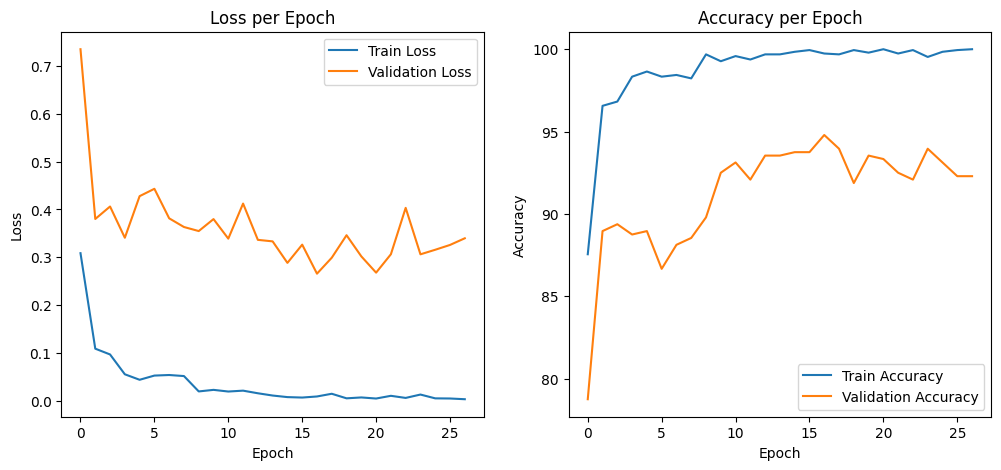

In [27]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
from tqdm import tqdm

NUM_EPOCHS = 100
LOSS_THRESHOLD = 0.01  # Ngưỡng giá trị loss để dừng huấn luyện
PATIENCE = 10  # Số epoch mà loss được phép không giảm trước khi dừng huấn luyện

# Lưu lại loss và accuracy cho việc vẽ biểu đồ
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Khởi tạo biến để theo dõi số epoch không cải thiện
no_improvement_count = 0
best_loss = float('inf')

# Sử dụng optimizer Adam và ReduceLROnPlateau scheduler
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Training loop
for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    val_correct = 0
    val_total = 0

    print('Epoch [%d/%d]' % (epoch + 1, NUM_EPOCHS))

    # Training phase
    model.train()
    epoch_train_loss = 0

    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda()

        # Forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

        # Tính accuracy trên tập huấn luyện
        _, predicted = torch.max(outputs.data, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()

    # Tính loss trung bình và accuracy cho mỗi epoch
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)

    print(f'Average Training Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

    # Validation phase
    model.eval()
    epoch_val_loss = 0

    with torch.no_grad():
        for inputs, targets in tqdm(val_loader):
            inputs, targets = inputs.cuda(), targets.cuda()

            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                loss = criterion(outputs, targets)
            else:
                targets = targets.squeeze().long()
                loss = criterion(outputs, targets)

            epoch_val_loss += loss.item()

            # Tính accuracy trên tập validation
            _, predicted = torch.max(outputs.data, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

    # Tính loss trung bình và accuracy cho tập validation
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * val_correct / val_total
    val_accuracies.append(val_accuracy)

    print(f'Average Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    # Kiểm tra điều kiện dừng
    if avg_val_loss < LOSS_THRESHOLD:
        print(f'Training stopped early at epoch {epoch + 1} due to loss threshold reached.')
        break

    # Kiểm tra xem loss có giảm hay không
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        no_improvement_count = 0  # Reset số epoch không cải thiện
    else:
        no_improvement_count += 1

    if no_improvement_count >= PATIENCE:
        print(f'Training stopped early at epoch {epoch + 1} due to no improvement in loss.')
        break

    # Bước scheduler để giảm learning rate nếu cần
    scheduler.step(avg_val_loss)

    if (epoch + 1) % 1 == 0:
        # Define the file path for saving the entire model
        model_path = f'/content/drive/My Drive/model_{name_model}_{epoch + 1}.pt'
        # Save the entire model
        torch.save(model.state_dict(), model_path)

# Vẽ biểu đồ đường giảm của hàm loss và đường tăng của accuracy
plt.figure(figsize=(12, 5))

# Vẽ biểu đồ loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

# Vẽ biểu đồ accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()


Model đã dùng

In [28]:
def load_model(model, model_path):
    model.load_state_dict(torch.load(model_path))
    return model

In [33]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1-ZX0x1sErE9-kvZDzZhht8HoUVyGTwXW -O /content/model.pth
device = torch.device('cuda')
model= load_model(model,'/content/model.pth')
model.eval()
model = model.cuda()

Downloading...
From (original): https://drive.google.com/uc?id=1-ZX0x1sErE9-kvZDzZhht8HoUVyGTwXW
From (redirected): https://drive.google.com/uc?id=1-ZX0x1sErE9-kvZDzZhht8HoUVyGTwXW&confirm=t&uuid=e9f78c53-a1f0-4aad-8b25-6b8ddfabfb34
To: /content/model.pth
100% 274M/274M [00:02<00:00, 93.0MB/s]


#Đánh giá

In [34]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import torch

model.eval()
y_true = []
y_score = []

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.cuda()
        outputs = model(inputs)
        outputs = outputs.softmax(dim=-1)
        y_score.extend(outputs.cpu().numpy())
        y_true.extend(targets.cpu().numpy())

# Chuyển đổi list sang numpy array
y_score = np.array(y_score)
y_true = np.array(y_true)

# In ra hình dạng của y_true để kiểm tra
print("Hình dạng ban đầu của y_true:", y_true.shape)

# Nếu y_true là mảng one-hot encoded, chuyển nó về dạng nhãn lớp
if y_true.ndim > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)
    print("Hình dạng của y_true sau khi chuyển đổi:", y_true.shape)
else:
    print("y_true đã ở dạng nhãn lớp.")

# In ra hình dạng của y_score để kiểm tra
print("Hình dạng của y_score:", y_score.shape)

# Đánh giá mô hình
accuracy = accuracy_score(y_true, np.argmax(y_score, axis=1))
try:
    if y_score.shape[1] == 2:  # Trường hợp nhị phân
        auc_score = roc_auc_score(y_true, y_score[:, 1])  # Sử dụng xác suất của lớp dương
    else:  # Trường hợp đa lớp
        auc_score = roc_auc_score(y_true, y_score, multi_class='ovr')
except ValueError as e:
    print(f"Lỗi khi tính toán AUC: {e}")
    auc_score = None

class_report = classification_report(y_true, np.argmax(y_score, axis=1))

print('Accuracy:', accuracy)
print('AUC:', auc_score)
print('Classification Report:')
print(class_report)



Hình dạng ban đầu của y_true: (480,)
y_true đã ở dạng nhãn lớp.
Hình dạng của y_score: (480, 3)
Accuracy: 0.9479166666666666
AUC: 0.9902419756279407
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       180
         1.0       0.84      0.98      0.90       110
         2.0       0.99      0.88      0.93       190

    accuracy                           0.95       480
   macro avg       0.94      0.95      0.94       480
weighted avg       0.95      0.95      0.95       480



#Thử nghiệm trên tập test

In [35]:
images = test_images_augmented
labels = test_labels_augmented

BATCH_SIZE = 1


test_dataset = DiseaseData(images, labels)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import torch

model.eval()
y_true = []
y_score = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.cuda()
        outputs = model(inputs)
        outputs = outputs.softmax(dim=-1)
        y_score.extend(outputs.cpu().numpy())
        y_true.extend(targets.cpu().numpy())

# Chuyển đổi list sang numpy array
y_score = np.array(y_score)
y_true = np.array(y_true)

# In ra hình dạng của y_true để kiểm tra
print("Hình dạng ban đầu của y_true:", y_true.shape)

# Nếu y_true là mảng one-hot encoded, chuyển nó về dạng nhãn lớp
if y_true.ndim > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)
    print("Hình dạng của y_true sau khi chuyển đổi:", y_true.shape)
else:
    print("y_true đã ở dạng nhãn lớp.")

# In ra hình dạng của y_score để kiểm tra
print("Hình dạng của y_score:", y_score.shape)

# Đánh giá mô hình
accuracy = accuracy_score(y_true, np.argmax(y_score, axis=1))
try:
    if y_score.shape[1] == 2:  # Trường hợp nhị phân
        auc_score = roc_auc_score(y_true, y_score[:, 1])  # Sử dụng xác suất của lớp dương
    else:  # Trường hợp đa lớp
        auc_score = roc_auc_score(y_true, y_score, multi_class='ovr')
except ValueError as e:
    print(f"Lỗi khi tính toán AUC: {e}")
    auc_score = None

class_report = classification_report(y_true, np.argmax(y_score, axis=1))

print('Accuracy:', accuracy)
print('AUC:', auc_score)
print('Classification Report:')
print(class_report)


Hình dạng ban đầu của y_true: (48,)
y_true đã ở dạng nhãn lớp.
Hình dạng của y_score: (48, 3)
Accuracy: 0.9375
AUC: 0.9896413489879915
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        18
         1.0       0.83      0.91      0.87        11
         2.0       0.94      0.89      0.92        19

    accuracy                           0.94        48
   macro avg       0.93      0.93      0.93        48
weighted avg       0.94      0.94      0.94        48

